# Sentiment Analysis on Amazon Reviews:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from tqdm.notebook import tqdm  
tqdm.pandas()  # Enable progress_apply on pandas DataFrame
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Read data
df = pd.read_csv("/workspaces/sentiment_analysis/Reviews.csv")

In [14]:
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

## 1- Exploratory Data Analysis:

In [15]:
df.shape

(568454, 10)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [17]:
df.describe()

Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
std    164098.679298              7.636513                 8.28974   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   

               Score          Time  
count  568454.000000  5.684540e+05  
mean        4.183199  1.296257e+09  
std         1.310436  4.804331e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.271290e+09  
50%         5.000000  1.311120e+09  
75%         5.000000  1.332720e+09  
max         5.000000  1.351210e+09

<function matplotlib.pyplot.show(close=None, block=None)>

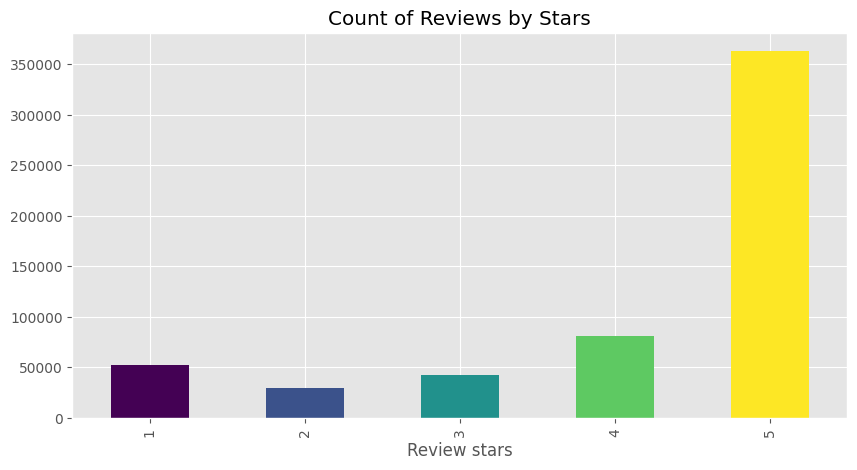

In [18]:
ax = df["Score"].value_counts().sort_index().plot(
    kind = 'bar', 
    title= "Count of Reviews by Stars", 
    figsize=(10,5),
    color=plt.cm.viridis(np.linspace(0, 1, len(df["Score"].unique())))
    )
ax.set_xlabel("Review stars")
plt.show

In [19]:
df["rating"] = df["Score"].map(lambda rating: "positive" if rating > 3 else "negative")

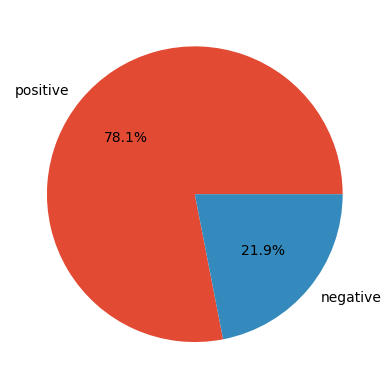

In [20]:
plt.pie(df["rating"].value_counts(), 
        labels = df["rating"].unique().tolist(),
        autopct='%1.1f%%')
plt.show()

#### Count and length:
- Character count
- Word count
- Mean word length
- Mean sentence length
- Mean of the above across the dataset

In [21]:
df["character_count"] = df["Text"].apply(lambda text: len(text))
df["word_count"] = df["Text"].apply(lambda text: len(text.split()))
df["mean_word_length"] = df["Text"].apply(lambda text: round(sum(len(word) for word in text.split()) / len(text.split()))if text else 0)
df["mean_sentence_length"] = df["Text"].apply(lambda text: round(sum(len(sent) for sent in text.split(".")) / len(text.split(".")))if text else 0)

In [22]:
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3         Cough Medicine  If you are looking for the secret ingredient i...   
4            Great taffy  Great taffy at a great price.  There was a wid...   

     rating  character_count  word_count  mean_word_length  \
0  positive              263          48                 4   
1  negative              190          31                 5   
2  positive              509          94                 4   
3  negative              219          41                 4   
4  positive              140          27                 4   

   mean_sentence_length  
0                    65  
1                    31  
2                    50  
3                    54  
4                    27

In [23]:
mean_character_length = round(df["character_count"].mean())
mean_word_count = round(df["word_count"].mean())
mean_word_length_all_reviews = round(df["mean_word_length"].mean())
mean_sentence_length_all_reviews = round(df["mean_sentence_length"].mean())
print("Mean character length across all reviews: {}\nMean word count across all reviews: {}\nMean word length across all reviews: {}\nMean sentence length across all reviews: {}".format(mean_character_length, mean_word_count, mean_word_length_all_reviews, mean_sentence_length_all_reviews))

Mean character length across all reviews: 436
Mean word count across all reviews: 80
Mean word length across all reviews: 4
Mean sentence length across all reviews: 67


In [24]:
def visualize(col):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df[col], x=df["rating"])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x=col, hue="rating")
    plt.legend(df["rating"].unique())
    plt.xlabel(col)

    plt.show()

In [25]:
features = df.columns.tolist()[11:]
features

['character_count', 'word_count', 'mean_word_length', 'mean_sentence_length']

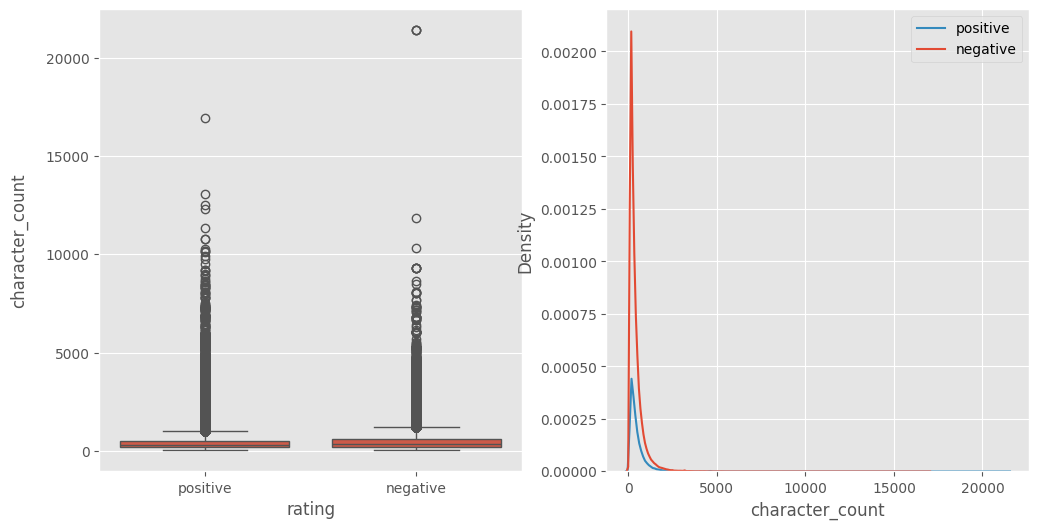

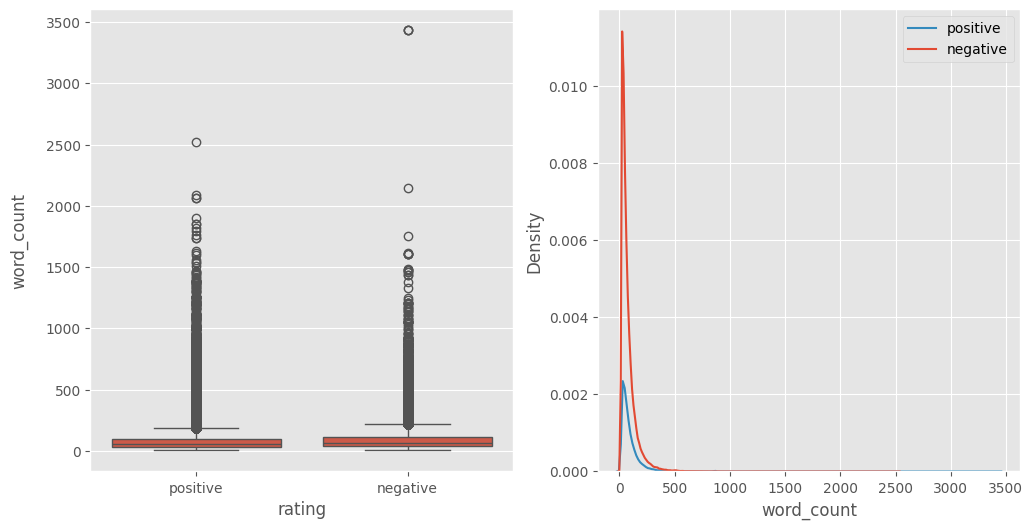

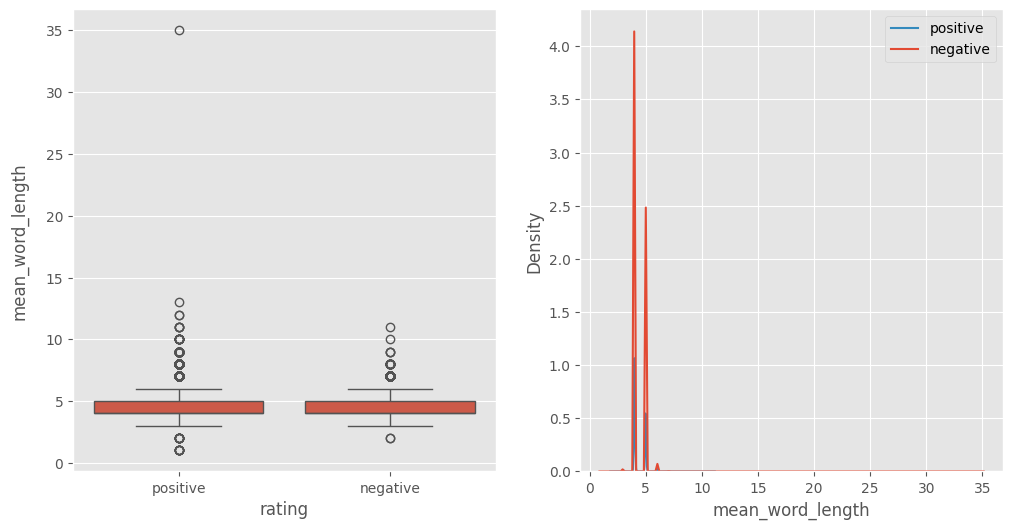

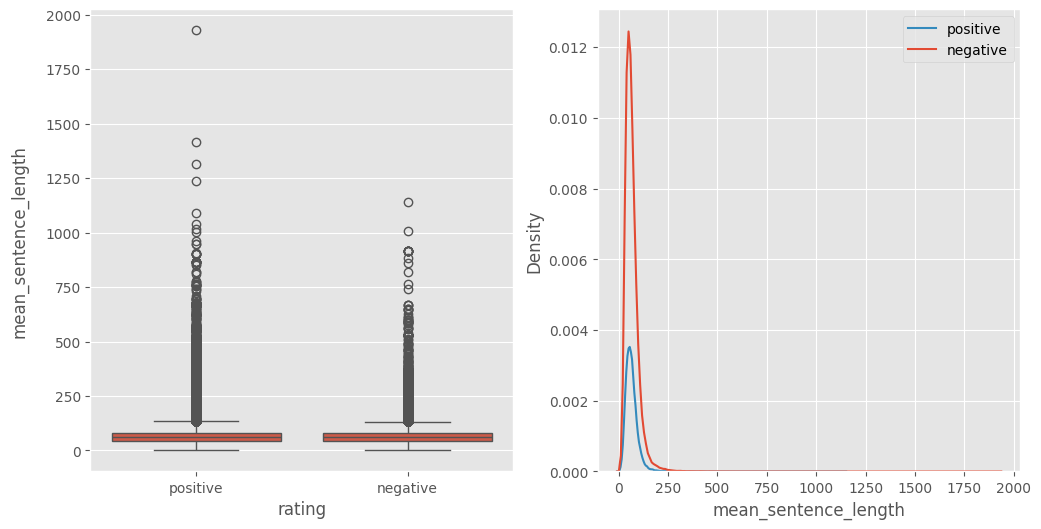

In [26]:
for feature in features:
    visualize(feature)

#### Most used/ frequent words and n-grams

In [27]:
def most_frequent_words(df, n =20):
    cv = CountVectorizer(stop_words="english", max_features= 1000)
    words = cv.fit_transform(df["Text"])
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse= True)
    frequency = pd.DataFrame(words_freq[:n], columns = ["word", "freq"])
    return frequency

In [28]:
most_frequency = most_frequent_words(df)

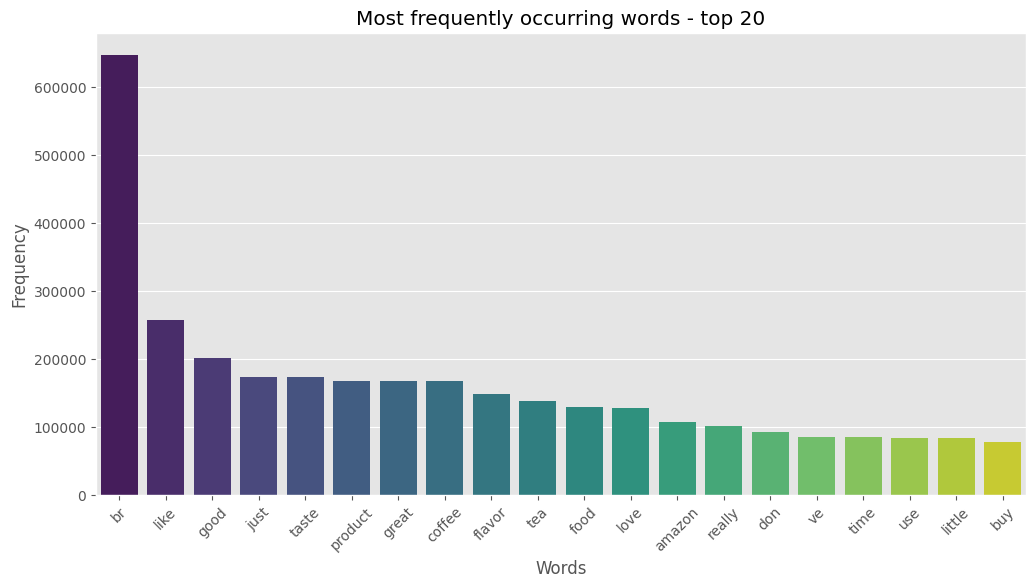

In [29]:
plt.figure(figsize = (12,6))
sns.barplot(x ="word", y="freq", data=most_frequency, palette="viridis")
plt.title("Most frequently occurring words - top {}".format(20))
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [30]:
def least_frequent_words(df, n =20):
    cv = CountVectorizer(stop_words="english", max_features= 1000)
    words = cv.fit_transform(df["Text"])
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1])
    frequency = pd.DataFrame(words_freq[:n], columns = ["word", "freq"])
    return frequency

In [31]:
least_frequency= least_frequent_words(df)

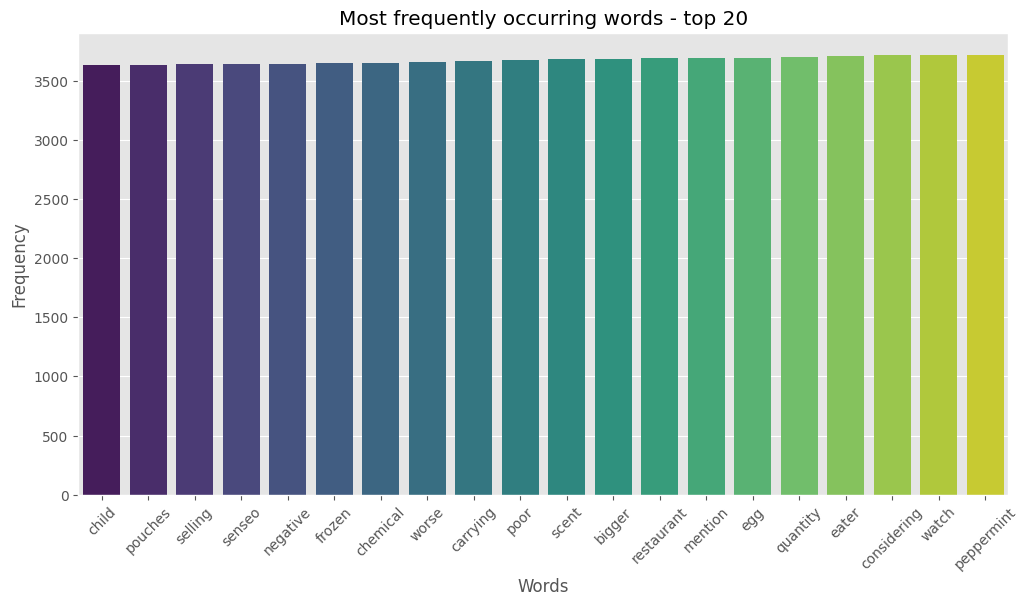

In [32]:
plt.figure(figsize = (12,6))
sns.barplot(x ="word", y="freq", data=least_frequency, palette="viridis")
plt.title("Most frequently occurring words - top {}".format(20))
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [33]:
# Most 100 frequent words in a wordcloud
frequency = most_frequent_words(df, 100)
word_freq_dict = dict(zip(frequency["word"], frequency["freq"]))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

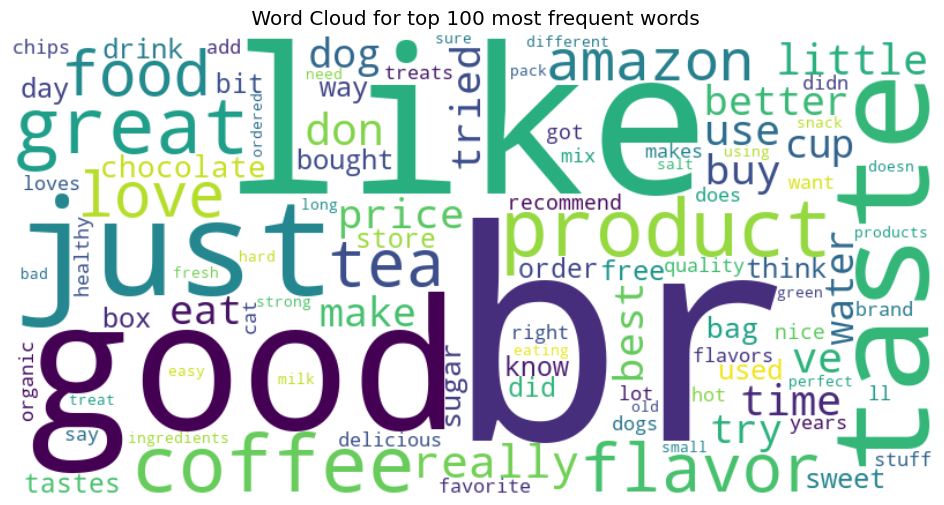

In [34]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(" Word Cloud for top 100 most frequent words")
plt.axis('off')
plt.show()

## 2- Unsupervised sentiment prediction: 
### 1- NLTK

In [35]:
def clean_text(text):
    text = str.lower(text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('','', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    cleaned_text = ' '.join(lemmatized_tokens)
    return cleaned_text

In [38]:
#Sample the data to 1000 rows
sampled_df = df.groupby("Score", group_keys=False).apply(lambda x: x.sample(n=200))
sampled_df.reset_index(drop=True, inplace=True)
sampled_df["Text"] = sampled_df["Text"].apply(lambda text: clean_text(text))
sampled_df.head()

Id   ProductId          UserId                          ProfileName  \
0  424436  B003C09PC4   AKJOL2Y2XJT00             Nicholas Walker "Savage"   
1  167162  B002HQE11O  A1K6IF77MPVILO                              Melissa   
2  489021  B005K4Q1YA  A2DVBV9RBHH2MW                             dwpersel   
3  346108  B004TJF3BE  A2D11X0Z1N5R93  Theresa Davis "Belgian to the Bone"   
4   35346  B000GW46D4  A3Q816H5AFX2SB                      J. Luk "Techie"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       1      1  1290124800   
1                     1                       2      1  1348876800   
2                     1                       2      1  1323129600   
3                     1                       1      1  1322352000   
4                     1                       1      1  1263254400   

                                       Summary  \
0                                  Disgusting!   
1                               waste of money   
2                                Don't buy it!   
3                        Such a disappointment   
4  Like licking a salt cube! 1470mg of Sodium!   

                                                Text    rating  \
0  didnt care taste like old salty ham horrible c...  negative   
1  really wanted like im baker always looking new...  negative   
2  sickenly sweet artificial tasting im getting r...  negative   
3  bought coffee shop area delicious carmel apple...  negative   
4  trying teriyaki flavor beef steak decided woul...  negative   

   character_count  word_count  mean_word_length  mean_sentence_length  
0              202          40                 4                    33  
1              811         151                 4                    44  
2              131          25                 4                    32  
3              177          34                 4                    44  
4              469          85                 4                    93

In [39]:
example = sampled_df["Text"][1]
print(example)

really wanted like im baker always looking new better way get vanilla seemed amazing really disappointed like sugary syrup faint vanilla taste ever used pure vanilla bean vanilla taste intense wasnt also tried buying vanilla powder williams sanoma even bigger waste money omg like ground peel something flavor hardly smell disappointment continue search saw website called vanilla man want check he africa think im hoping real deal vanilla syrup powder grinder well see could another waste money im always trying till find something good


In [41]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['really',
 'wanted',
 'like',
 'im',
 'baker',
 'always',
 'looking',
 'new',
 'better',
 'way']

In [42]:
nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('really', 'RB'),
 ('wanted', 'VBN'),
 ('like', 'IN'),
 ('im', 'JJ'),
 ('baker', 'NN'),
 ('always', 'RB'),
 ('looking', 'VBG'),
 ('new', 'JJ'),
 ('better', 'JJR'),
 ('way', 'NN')]

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


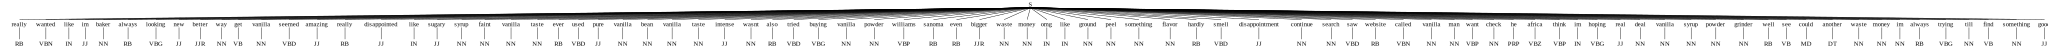

In [43]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.chunk.ne_chunk(tagged)

### VADER sentiment scoring:
- This uses a "bag of words" approach: </br>
    1- Stop words removal </br>
    2- Each word is scored and combined into a total score </br>

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sia.polarity_scores("I am very happy")

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [ ]:
sia.polarity_scores("I am not happy")

{'neg': 0.6, 'neu': 0.4, 'pos': 0.0, 'compound': -0.4585}

In [ ]:
sia.polarity_scores(example)

{'neg': 0.102, 'neu': 0.821, 'pos': 0.077, 'compound': -0.2263}

In [ ]:
# Run the polarity score on the data
sampled_df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = sampled_df["Text"].apply(lambda text: pd.Series(sia.polarity_scores(text)))

In [ ]:
sampled_df.head()

Id   ProductId          UserId   ProfileName  HelpfulnessNumerator  \
0  272768  B0036VLZNG  A1I0EXQD49LPFA       jsparks                     1   
1  192536  B006GA666U   A85PB2BX6O8XA    Mark Twain                     0   
2  104735  B006N3I69A  A13TOSL8QG2BD6         Bobbi                     0   
3  261128  B0012KB47K  A36UYMAJ9CNSAI  Fran Pearson                     0   
4  105609  B000K8XM2A  A2GW16350CJXJX    C. Lashley                     0   

   HelpfulnessDenominator  Score        Time  \
0                       2      1  1336694400   
1                       1      1  1323907200   
2                       0      1  1307577600   
3                       3      1  1267747200   
4                       1      1  1225670400   

                                          Summary  \
0                           Worse soup I ever ate   
1                       Emeril Doesn't Know Beans   
2                             Would not recommend   
3               my cat turned up his nose at this   
4  was really loking forward to a good cracker...   

                                                Text    rating  \
0  couldnt even get soup past nose bad try though...  negative   
1  coffee dark roast pas sale emerils plus coupon...  negative   
2  cup simply little plastic container coffee gro...  negative   
3     kitty would eat gave whole pack animal shelter  negative   
4  wellthis product isnt cruchy like chip used he...  negative   

   character_count  word_count  mean_word_length  mean_sentence_length  \
0              232          45                 4                    46   
1              781         151                 4                    70   
2              405          69                 5                    36   
3               72          14                 4                    23   
4              878         174                 4                    67   

   vader_neg  vader_neu  vader_pos  vader_compound  
0      0.259      0.741      0.000         -0.7906  
1      0.102      0.821      0.077         -0.2263  
2      0.276      0.678      0.046         -0.8811  
3      0.000      1.000      0.000          0.0000  
4      0.049      0.676      0.275          0.9722

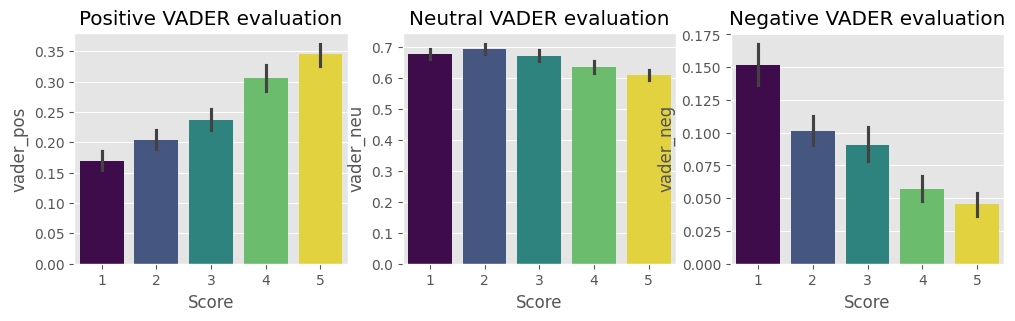

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=sampled_df, x="Score", y="vader_pos", ax= axs[0], hue="Score", palette="viridis", legend=False)
sns.barplot(data=sampled_df, x="Score", y="vader_neu", ax= axs[1], hue="Score", palette="viridis", legend=False)
sns.barplot(data=sampled_df, x="Score", y="vader_neg", ax= axs[2], hue="Score", palette="viridis", legend=False)
axs[0].set_title("Positive VADER evaluation")
axs[1].set_title("Neutral VADER evaluation")
axs[2].set_title("Negative VADER evaluation")
plt.show()

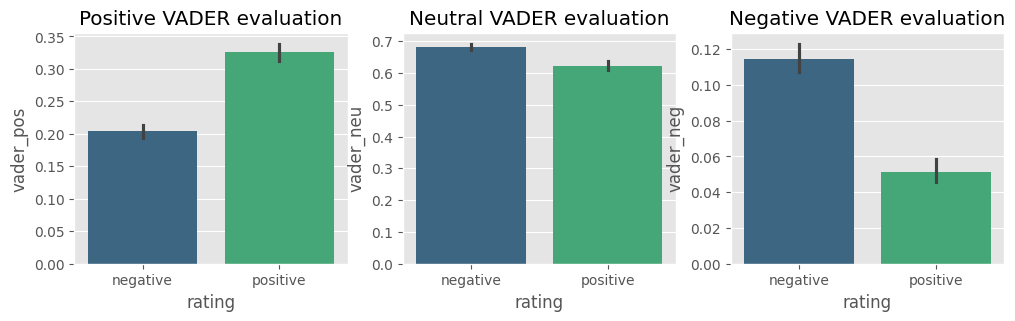

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=sampled_df, x="rating", y="vader_pos", ax= axs[0], hue="rating", palette="viridis", legend=False)
sns.barplot(data=sampled_df, x="rating", y="vader_neu", ax= axs[1], hue="rating", palette="viridis", legend=False)
sns.barplot(data=sampled_df, x="rating", y="vader_neg", ax= axs[2], hue="rating", palette="viridis", legend=False)
axs[0].set_title("Positive VADER evaluation")
axs[1].set_title("Neutral VADER evaluation")
axs[2].set_title("Negative VADER evaluation")
plt.show()

### 2- Transformers:

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")
model = AutoModelForSequenceClassification.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")

In [ ]:
print(example)

coffee dark roast pas sale emerils plus coupon known better expecting french italian level dark roast anticipating decent cup coffee big easy misnomer big zero add tablespoon halfhalf color coffee go tan thats telling darkness therein thats happened went taste stuff weak bitter undertone oddly taste first sip go though water added use ounce side keurig imagine large cup would right dishwater slug remaining kcups never purchase


In [ ]:
def polarity_scores_distelbert(text):
    encoded_text = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        "distelbert_pos": scores[0],
        "distelbert_neu": scores[1],
        "distelbert_neg": scores[2],
    }
    return scores_dict

In [ ]:
print(polarity_scores_distelbert(example))

{'distelbert_pos': 0.15651289, 'distelbert_neu': 0.16547003, 'distelbert_neg': 0.6780171}


In [ ]:
# Run the polarity score on the data
sampled_df[['distelbert_pos', 'distelbert_neu', 'distelbert_neg']] = sampled_df["Text"].progress_apply(lambda text: pd.Series(polarity_scores_distelbert(text)))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
sampled_df.head()

Id   ProductId          UserId   ProfileName  HelpfulnessNumerator  \
0  272768  B0036VLZNG  A1I0EXQD49LPFA       jsparks                     1   
1  192536  B006GA666U   A85PB2BX6O8XA    Mark Twain                     0   
2  104735  B006N3I69A  A13TOSL8QG2BD6         Bobbi                     0   
3  261128  B0012KB47K  A36UYMAJ9CNSAI  Fran Pearson                     0   
4  105609  B000K8XM2A  A2GW16350CJXJX    C. Lashley                     0   

   HelpfulnessDenominator  Score        Time  \
0                       2      1  1336694400   
1                       1      1  1323907200   
2                       0      1  1307577600   
3                       3      1  1267747200   
4                       1      1  1225670400   

                                          Summary  \
0                           Worse soup I ever ate   
1                       Emeril Doesn't Know Beans   
2                             Would not recommend   
3               my cat turned up his nose at this   
4  was really loking forward to a good cracker...   

                                                Text  ... word_count  \
0  couldnt even get soup past nose bad try though...  ...         45   
1  coffee dark roast pas sale emerils plus coupon...  ...        151   
2  cup simply little plastic container coffee gro...  ...         69   
3     kitty would eat gave whole pack animal shelter  ...         14   
4  wellthis product isnt cruchy like chip used he...  ...        174   

   mean_word_length  mean_sentence_length  vader_neg  vader_neu  vader_pos  \
0                 4                    46      0.259      0.741      0.000   
1                 4                    70      0.102      0.821      0.077   
2                 5                    36      0.276      0.678      0.046   
3                 4                    23      0.000      1.000      0.000   
4                 4                    67      0.049      0.676      0.275   

   vader_compound  distelbert_pos  distelbert_neu  distelbert_neg  
0         -0.7906        0.066955        0.097991        0.835054  
1         -0.2263        0.156513        0.165470        0.678017  
2         -0.8811        0.048527        0.078209        0.873264  
3          0.0000        0.520197        0.237484        0.242318  
4          0.9722        0.667038        0.093563        0.239399  

[5 rows x 22 columns]

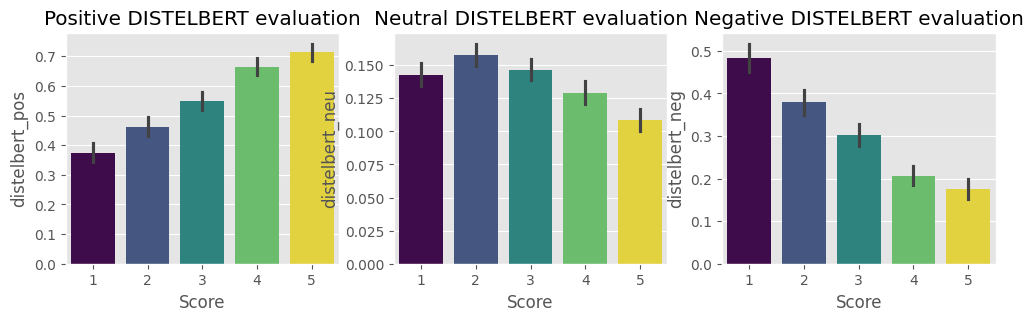

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=sampled_df, x="Score", y="distelbert_pos", ax= axs[0], hue="Score", palette="viridis", legend=False)
sns.barplot(data=sampled_df, x="Score", y="distelbert_neu", ax= axs[1], hue="Score", palette="viridis", legend=False)
sns.barplot(data=sampled_df, x="Score", y="distelbert_neg", ax= axs[2], hue="Score", palette="viridis", legend=False)
axs[0].set_title("Positive DISTELBERT evaluation")
axs[1].set_title("Neutral DISTELBERT evaluation")
axs[2].set_title("Negative DISTELBERT evaluation")
plt.show()

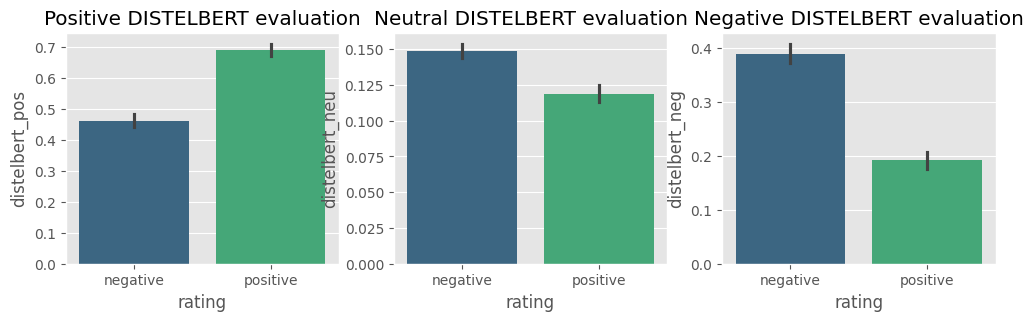

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=sampled_df, x="rating", y="distelbert_pos", ax= axs[0], hue="rating", palette="viridis", legend=False)
sns.barplot(data=sampled_df, x="rating", y="distelbert_neu", ax= axs[1], hue="rating", palette="viridis", legend=False)
sns.barplot(data=sampled_df, x="rating", y="distelbert_neg", ax= axs[2], hue="rating", palette="viridis", legend=False)
axs[0].set_title("Positive DISTELBERT evaluation")
axs[1].set_title("Neutral DISTELBERT evaluation")
axs[2].set_title("Negative DISTELBERT evaluation")
plt.show()

## 3- Comparing the results:

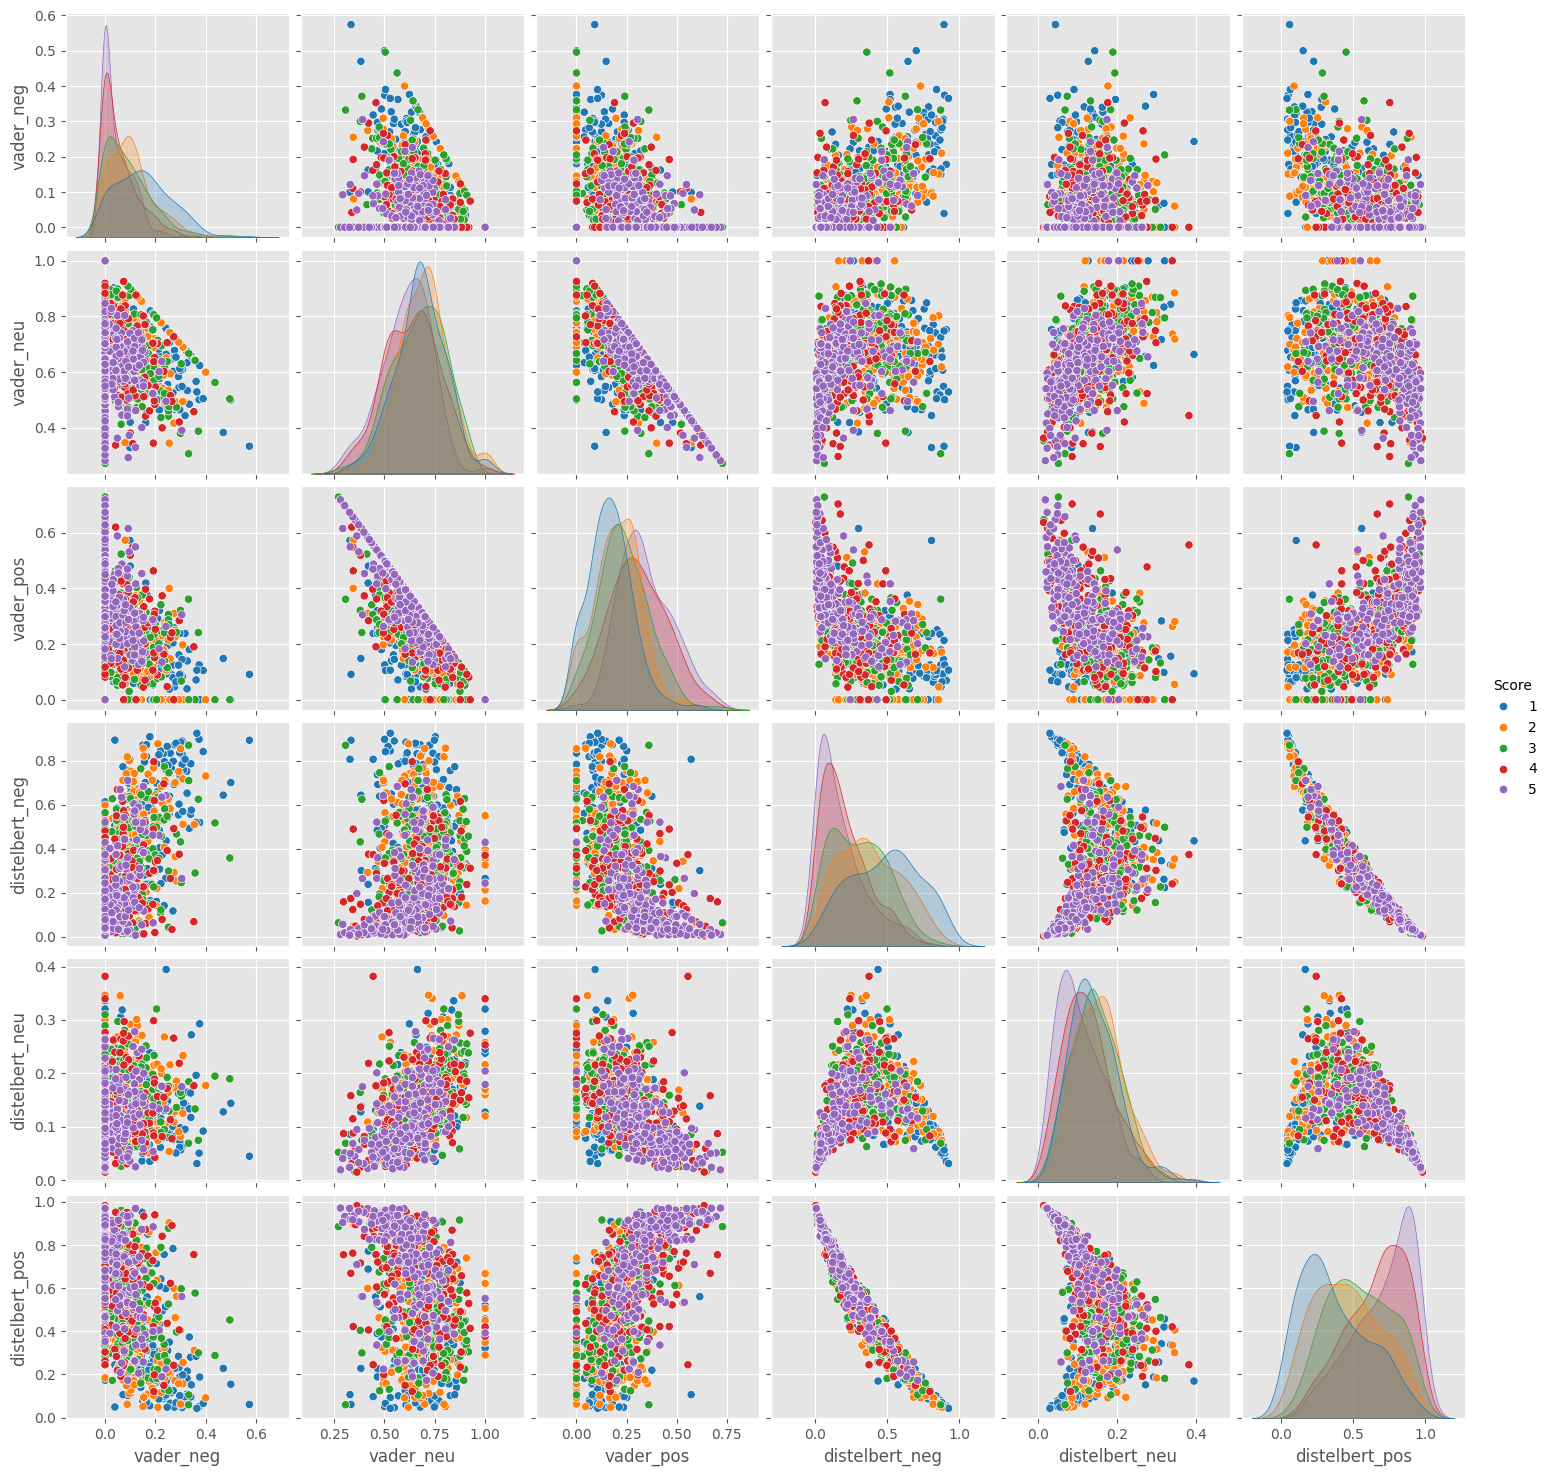

In [ ]:
sns.pairplot(
    data= sampled_df,
    vars = ["vader_neg","vader_neu","vader_pos" , "distelbert_neg", "distelbert_neu", "distelbert_pos"],
    hue = "Score",
    palette="tab10"
)
plt.show()

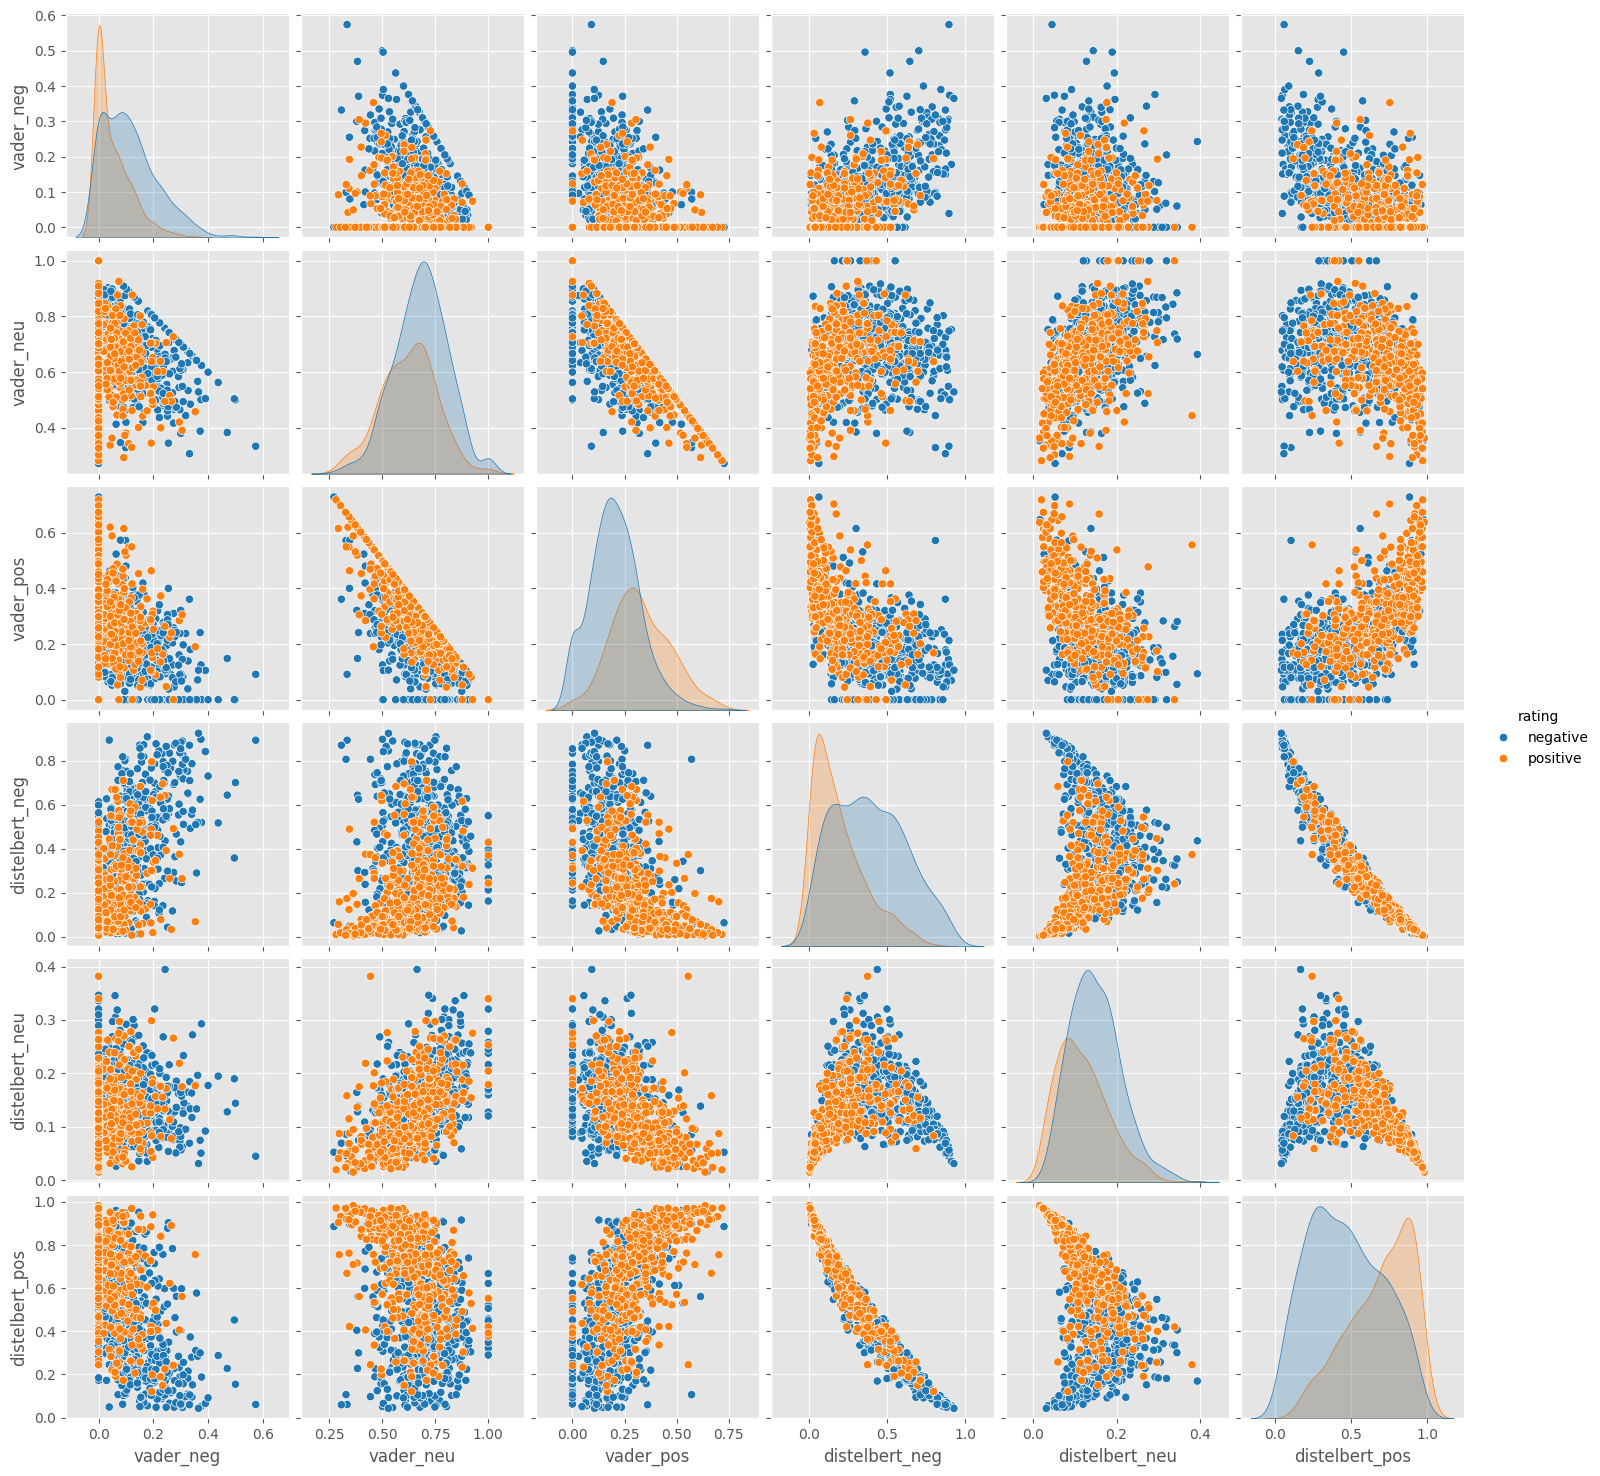

In [ ]:
sns.pairplot(
    data= sampled_df,
    vars = ["vader_neg","vader_neu","vader_pos" , "distelbert_neg", "distelbert_neu", "distelbert_pos"],
    hue = "rating",
    palette="tab10"
)
plt.show()

Both models are able to seperate the positive and negative reviews, while the distelbert better differentiates the score ranking by having a decreasing density the lower the score for the negative ranking: the 5 star ratings have a higher density with lower negative values for the negative distelbert evaluations, this same behavior decreases gradually the more the score decrease until reaching 1. This is simplified in the comparaison plots of negative and positive ratings: the distelbert achives a better pattern recognition thus a better job at seperating the positive and negative reviews
For the neutral values, the densities seem to follow each other in the two models wheras the vader model gives higher neutral values.

## 4- Review examples:

Looking at the top rated positive reviews with vader and distelbert while scoring a 1 star.

In [ ]:
sampled_df.query("Score == 1").sort_values("distelbert_pos", ascending= False)["Text"].values[0]

'bought bar ingredient nutritional analysisbr good bar awful taste super small price wish could return bar left rip bar pay eat'

In [ ]:
sampled_df.query("Score == 1").sort_values("vader_pos", ascending= False)["Text"].values[0]

'like burnt cheese snack im fan im sure someone like'

In [ ]:
sampled_df.query("Score == 5").sort_values("distelbert_neg", ascending= False)["Text"].values[0]

'bacon flavor lickety stik like crack cocaine dog rocky handed product would goneplastic allwithin second however arent supposed give dog lickety stick work like rollon deodorant human hold dog lick dog reacts like rocky youll get big kick novelty wont wear rocky distinct impression ill get bored whilebr br paw mr peabody seemed enjoy wasnt enthusiastic rocky could difference age mr p six year old rocky one rocky also eats everything including light bulb styptic powder prescription eyewear much vigor attacked lickety stikbr br third dog charity sniffed looked like serious issue turned away shes seven based rockys mr p enjoyment product give five star charity dog would get none'

In [ ]:
sampled_df.query("Score == 5").sort_values("vader_neg", ascending= False)["Text"].values[0]

'recipe used label super muffin waffle die'

## 5 - Supervised: 
In this section, I'll consider the labels positive and negative (established in the beginning of the notebook) following this process: </br>
    - Score =< 3: negative review </br>
    - Score > 3: positive review </br>


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score , GridSearchCV , KFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [5]:
df["Sentiment"] = df["Score"].map(lambda score: 1 if score > 3 else 0)
dfs = df.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(frac=0.1))
dfs.head()

Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
269246  269247  B003S9GWU2  A25W56ML0PB3SM    shambala                     1   
246141  246142  B0009F3SBY  A2ADMKAMXLOQ6J    G. Knize                    63   
479874  479875  B001E5E2BS  A2PL7A9S8VD3M6     SB "SB"                     4   
401247  401248  B001EQ5GGM  A3O9H969Z41NHC     tbone13                     0   
239327  239328  B00008DFK5  A1HJ0ED9N86W3H         LIB                     0   

        HelpfulnessDenominator  Score        Time  \
269246                       9      1  1299801600   
246141                      65      1  1326585600   
479874                       9      2  1270857600   
401247                       3      1  1320537600   
239327                       0      3  1343088000   

                                            Summary  \
269246               This stuff stinks literally!!!   
246141  HEAT KILLS BENEFICIAL KOMBUCHA ORGANISMS!!!   
479874                               Poor packaging   
401247           these are good.. but not $38 good!   
239327     Using to give my dog her daily medicines   

                                                     Text  Sentiment  
269246  My cat Joshua is 13years old, he has been with...          0  
246141  I have always loved Yogi Teas and have many fl...          0  
479874  This was delivered a complete mess.  I left fe...          0  
401247  these were $24 a few months ago... now they wa...          0  
239327  My dog takes supplements everyday and has for ...          0

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(dfs["Text"], dfs["Sentiment"], test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=52)

In [7]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train)
X_val= vectorizer.transform(X_val)
X_test= vectorizer.transform(X_test)

In [8]:
def fine_tuning(param_grid, k_folds, classifier,X_train, y_train):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(" Best hyperparams: ", best_params)
    print("for the model : ", classifier)
    return best_params

In [9]:
def train(best_params, classifier,X_train, y_train):
    classifier.set_params(**best_params) 
    classifier.fit(X_train, y_train) 
    return classifier 

In [ ]:
def evaluation(best_model, X_val, y_val):
    val_predictions= best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    print("Validation Accuracy:", val_accuracy)
    print("Validation Report:")
    print(classification_report(y_val, val_predictions)) 

In [10]:
# Define classifiers
classifiers = {
    "knn_model" : KNeighborsClassifier(),
    "nb_model" : ComplementNB(),
    "lg_model" : LogisticRegression(max_iter=1000),
    "svm_model" : SVC(),
    'random_forest_model': RandomForestClassifier(),
    'gradient_boosting_model': GradientBoostingClassifier(),
}

In [ ]:
# # Richer version of params_grid
# param_grids = {
#     "knn_model" : {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
#     "nb_model" : {'alpha': [0.1, 0.5, 1.0, 2.0], 'fit_prior': [True, False]},
#     "lg_model" : {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
#     "svm_model" : {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']},
#     'random_forest_model': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
#     'gradient_boosting_model': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1]},
# }

In [11]:
param_grids = {
    "knn_model" : {'n_neighbors': [3, 5, 7],'weights': ['uniform', 'distance'],'metric': ['euclidean', 'manhattan']},
    "nb_model" : {'alpha': [0.1, 1.0],'fit_prior': [True]},
    "lg_model" : {'C': [0.01, 1],  'penalty': ['l1', 'l2'],'solver': ['liblinear']},
    "svm_model" : {'C': [0.1, 1], 'kernel': ['linear', 'rbf']},
    'random_forest_model': {'n_estimators': [50, 100], 'max_depth': [None, 10]},
    'gradient_boosting_model': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]},
}

In [12]:
# Train and evaluate each classifier
trained_models ={} # Dictionary to store trained models
best_params = {}
for clf_name, classifier in classifiers.items():
    print(f"Training and evaluating {clf_name}...")
    best_params[clf_name] = fine_tuning(param_grids[clf_name], 3, classifier,X_train, y_train)
    trained_models[clf_name] = train(best_params[clf_name], classifier,X_train, y_train)
    #evaluation(trained_models[clf_name], X_val, y_val)

Training and evaluating knn_model...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
 Best hyperparams:  {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
for the model :  KNeighborsClassifier()
Training and evaluating nb_model...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
 Best hyperparams:  {'alpha': 1.0, 'fit_prior': True}
for the model :  ComplementNB()
Training and evaluating lg_model...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Best hyperparams:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
for the model :  LogisticRegression(max_iter=1000)
Training and evaluating svm_model...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Best hyperparams:  {'C': 1, 'kernel': 'rbf'}
for the model :  SVC()
Training and evaluating random_forest_model...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Best hyperparams:  {'max_depth': None, 'n_estimators': 50}
for the model :  RandomForestClassifier()
Train

In [13]:
trained_models

{'knn_model': KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance'),
 'nb_model': ComplementNB(),
 'lg_model': LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='liblinear'),
 'svm_model': SVC(C=1),
 'random_forest_model': RandomForestClassifier(n_estimators=50),
 'gradient_boosting_model': GradientBoostingClassifier()}

#### Model comparaison:

In [18]:
# Define a function to evaluate models and collect metrics
def evaluate_models(trained_models, X_val, y_val):
    results = {}
    for name, model in trained_models.items():
        print(model)
        print(name)
        predictions = model.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        precision = precision_score(y_val, predictions)
        recall = recall_score(y_val, predictions)
        f1 = f1_score(y_val, predictions)
        roc_auc = roc_auc_score(y_val, predictions)
        results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1, 'ROC-AUC': roc_auc}
    return results

In [15]:
# Compare models
def compare_models(results):
    metrics = list(next(iter(results.values())).keys())
    for metric in metrics:
        values = [result[metric] for result in results.values()]
        plt.figure(figsize=(10, 5))
        plt.bar(results.keys(), values, color='skyblue')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.title(f'{metric} Comparison')
        plt.xticks(rotation=45)
        plt.show()

KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance')
knn_model
ComplementNB()
nb_model
LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='liblinear')
lg_model
SVC(C=1)
svm_model
RandomForestClassifier(n_estimators=50)
random_forest_model
GradientBoostingClassifier()
gradient_boosting_model
{'knn_model': {'Accuracy': 0.8161829375549692, 'Precision': 0.8334152334152334, 'Recall': 0.9554929577464789, 'F1-score': 0.8902887139107611, 'ROC-AUC': 0.6380671201558046}, 'nb_model': {'Accuracy': 0.8540017590149517, 'Precision': 0.928698752228164, 'Recall': 0.8805633802816901, 'F1-score': 0.9039907460960093, 'ROC-AUC': 0.8200412091789212}, 'lg_model': {'Accuracy': 0.8887423043095867, 'Precision': 0.903072033898305, 'Recall': 0.9605633802816902, 'F1-score': 0.9309309309309309, 'ROC-AUC': 0.7969149566739111}, 'svm_model': {'Accuracy': 0.9001759014951627, 'Precision': 0.9086589229144667, 'Recall': 0.9695774647887324, 'F1-score': 0.9381302807304442, 'ROC-AUC': 0.811442

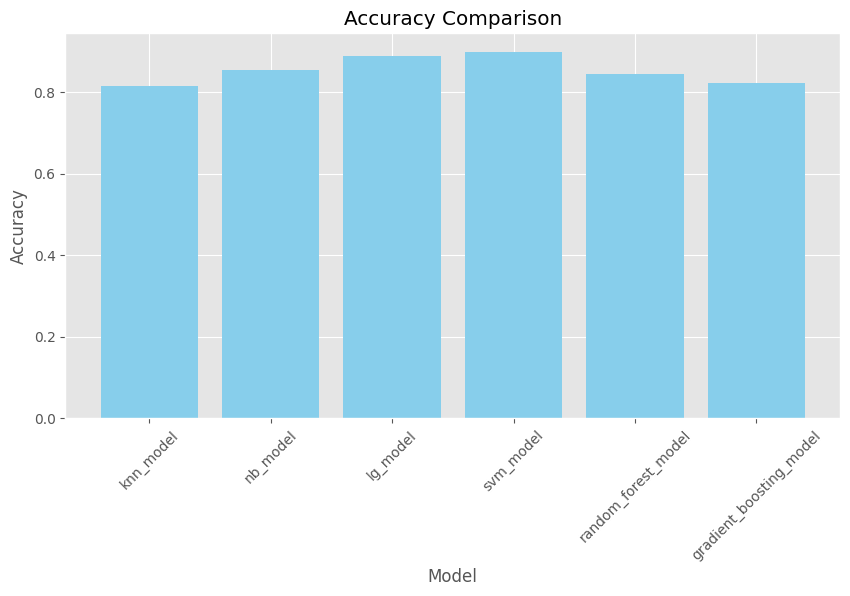

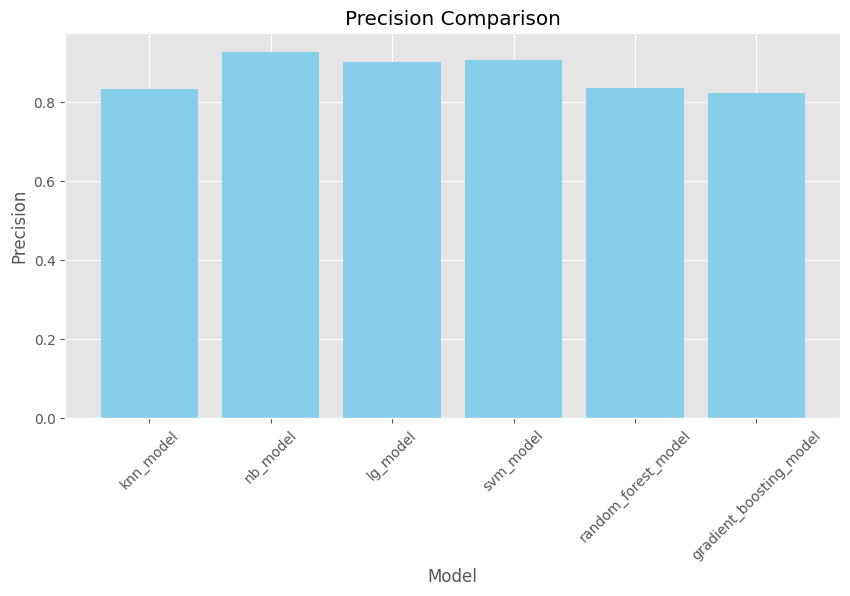

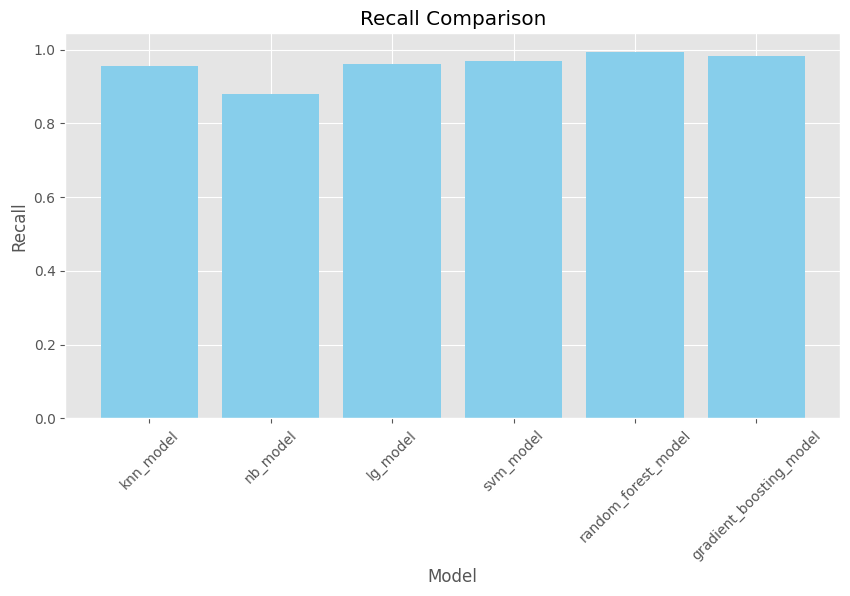

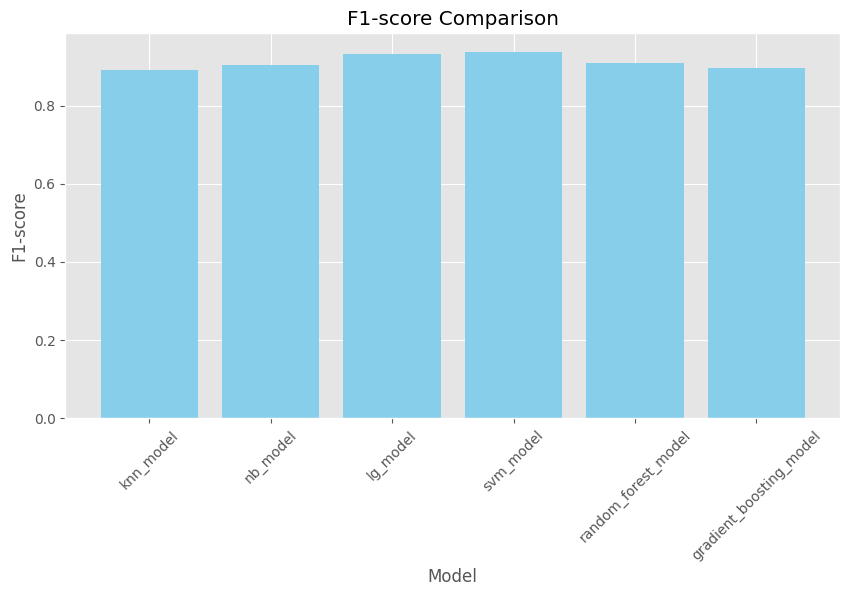

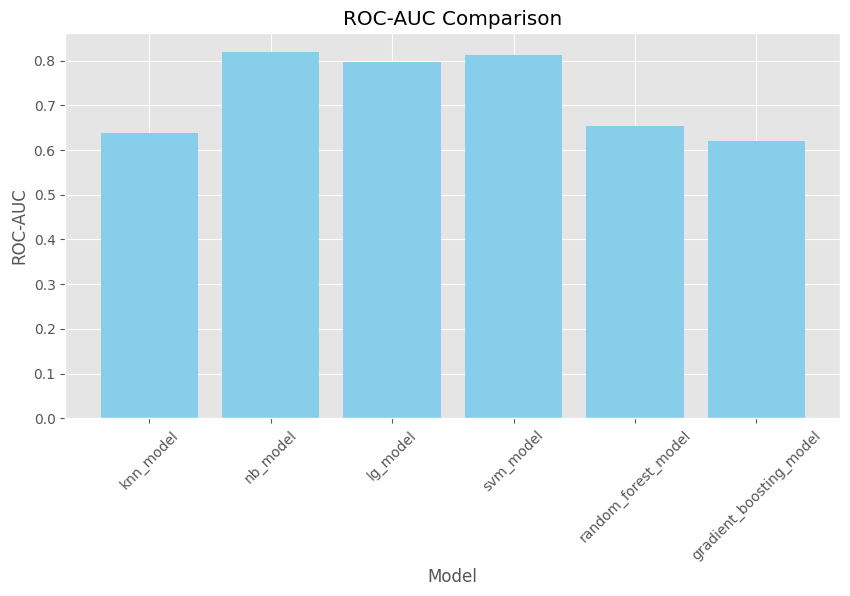

In [22]:
# Evaluate models on validation set
evaluation_results = evaluate_models(trained_models, X_val, y_val)
print(evaluation_results)
# Compare models based on various metrics
compare_models(evaluation_results)

In [21]:
example =["I think this product should not be used"]
example = vectorizer.transform(example)
trained_models['nb_model'].predict(example)

array([0])

The NB model has the best AUC score assesement